In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import autograd as ag
import numpy as np 
import os
import copy
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import corner
import pyccl as ccl

from tqdm import tqdm, trange

from scipy.interpolate import interp1d, UnivariateSpline
from scipy.optimize import curve_fit

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, ConstantKernel
from sklearn.decomposition import PCA


from numpy.polynomial import Chebyshev

import src.datamaker as datamaker
import src.training as training
import src.models as models

from importlib import reload
reload(datamaker)
reload(training)
reload(models)

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['cmr10']
plt.rcParams['mathtext.fontset'] ='cm'
plt.rcParams['figure.facecolor'] = 'white'
plt.rc('axes', unicode_minus=False)
plt.rc('axes.formatter', use_mathtext=True)

In [2]:
n_samples = 2048
n_tasks = 200

filename = 'data/Cgg_samples_{}tasks_{}samples.npz'.format(n_tasks, n_samples)

# Load in training data
if os.path.isfile(filename):
    with np.load(filename) as data:
        X_train = data['X_train']
        Y_train = data['Y_train']
        ell_bins = data['ell_bins']
        survey_midpoints = data['survey_midpoints']
        survey_pz = data['survey_pz']
        qrd_pz = data['qrd_pz']

print(X_train.shape)
print(Y_train.shape)

(200, 2048, 7)
(200, 2048, 30)


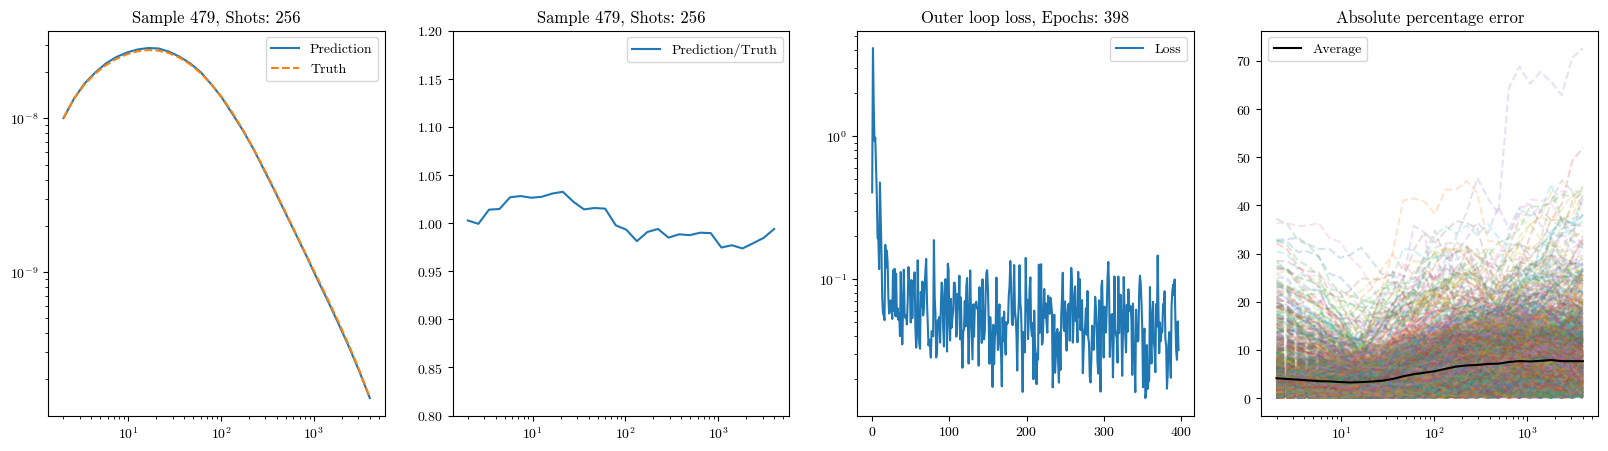

In [13]:
reload(training)

model = models.SimpleMLP(
            in_size=X_train.shape[2],
            hidden_size=512,
            out_size=Y_train.shape[2]
        )

# Take logarithm of spectra in Y_train
Y_train_log = np.log(Y_train)

# MAML train model
CosyMAML_log = training.Adam_MAML(
            model=model,
            seed=42
        )

loss_MAML_log = CosyMAML_log.meta_train(
    x_train=X_train,
    y_train=Y_train_log,
    inner_lr=0.001,
    outer_lr=0.01,
    inner_decay=1e-5,
    outer_decay=1e-4,
    loss_fn=nn.MSELoss(),
    spt_frac=0.5,
    outer_epochs=2,
    inner_epochs=5,
    plot_prog=False,
    n_shots=256,
    ell_bins=ell_bins,
)